# Evaluation of multi-omics GRN inference methods
## Preprocessing multi-omics data
### by Jalil Nourisa

# Imports 

In [1]:
import os
import gzip
import pandas as pd
import numpy as np
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.cluster import KMeans
from scipy.sparse import csr_matrix


import scanpy as sc
import matplotlib.pyplot as plt
import tqdm
import scipy
import seaborn as sns
import json
import anndata as ad
import warnings
# import decoupler as dc

# from venn import venn 

import matplotlib
matplotlib.rc('font', family='serif')
matplotlib.rc('text', usetex='false')
matplotlib.rcParams.update({'font.size': 10})

work_dir = '../../output'
kaggle_data_dir = '/beegfs/desy/user/nourisaj/openproblems_sc_perturbation/input/'
# kaggle_data_dir = '../../input/kaggle/input'
T_cells = ['T regulatory cells', 'T cells CD8+', 'T cells CD4+']
def func_leiden(adata):
    adata.layers['counts'] = adata.X.copy()
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, n_top_genes=2000)
    sc.tl.pca(adata, n_comps=50, use_highly_variable=True)
    sc.pp.neighbors(adata, n_pcs=30)
    sc.tl.umap(adata)
    sc.tl.leiden(adata)
def plot_umap(adata_o, color='leiden', ax=None, groups=None):
    adata = adata_o.copy()
    if groups is not None:
        adata.obs[color] = adata.obs[color].astype(str)
        mask = adata.obs[color].isin(groups)
        print(mask.sum())
        adata.obs.loc[~mask, color] = 'background'
    #     adata.obs['color'] = adata.obs['color'].astype(str).astype(categorical)
        
    x_data = adata.obsm['X_umap'][:,0]
    y_data = adata.obsm['X_umap'][:,1]
    xlim = [min(x_data)+.1*min(x_data), max(x_data)+.1*max(x_data)]
    ylim = [min(y_data)+.1*min(y_data), max(y_data)+.1*max(y_data)]
    if isinstance(adata.obs[color].iloc[0], (int, float)):
        # Continuous variable
        scatter = ax.scatter(x_data, y_data, c=adata.obs[color], cmap='viridis', alpha=0.3, s=1)
        plt.colorbar(scatter, ax=ax)
    else:
        unique_colors = adata.obs[color].unique()
        num_colors = len(unique_colors)
        if num_colors > 10:
            cmap = plt.get_cmap('tab20')  # Use a color map with more distinct colors
            color_list = cmap(np.linspace(0, 1, num_colors))
            color_list = [list(color_list[i]) for i in range(num_colors)]  # Convert each color to list format

        else:
            color_list = None  # Use default color map if fewer than 10 colors
            
        for i, c in enumerate(unique_colors):
            mask = adata.obs[color]==c
            if c == 'background':
                ax.scatter(x_data[mask], y_data[mask], s=.5, label=c, color='lightgrey', alpha=.01)
            else:
                ax.scatter(x_data[mask], y_data[mask], s=1, label=c, color=color_list[i] if color_list else None, alpha=.3)
            if color == 'leiden':
                avg_x = np.mean(x_data[mask])
                avg_y = np.mean(y_data[mask])
                ax.annotate(c, (avg_x, avg_y),ha='center', fontsize=15)

    ax.set_xlabel('UMAP1')
    ax.set_ylabel('UMAP2')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xticks([])
    ax.set_yticks([])

    if color!='leiden':
        legend = ax.legend(loc='upper left', bbox_to_anchor=(1,1), frameon=False)
        # legend = ax.legend()
        for handle in legend.legendHandles:
            handle.set_sizes([50])
    ax.set_title(color)
def plot_umap_group(adata, colors):
    n = len(colors)
    fig, axes = plt.subplots(1, n, figsize=(6*n, 4))
    for ii, color in enumerate(colors):
        plot_umap(adata, color=color, ax=axes[ii])
    plt.tight_layout()
    return fig


In [65]:
multiome_var_meta = pd.read_csv(f'{kaggle_data_dir}/open-problems-single-cell-perturbations/multiome_var_meta.csv')
multiome_train = pd.read_parquet(f'{kaggle_data_dir}/open-problems-single-cell-perturbations/multiome_train.parquet')
multiome_obs_meta = pd.read_csv(f'{kaggle_data_dir}/open-problems-single-cell-perturbations/multiome_obs_meta.csv')

FileNotFoundError: [Errno 2] No such file or directory: '/beegfs/desy/user/nourisaj/openproblems_sc_perturbation/input//open-problems-single-cell-perturbations/multiome_var_meta.csv'

# scRNA-seq
We use provided normalized values as X and store the counts in the layers.

## Formatize the data

In [4]:

genes_locations = multiome_var_meta[multiome_var_meta['feature_type']=='Gene Expression']['location'].values
df_mrna = multiome_train[multiome_train['location'].isin(genes_locations)].reset_index(drop=True)
# get count and normalized count
df_mrna_pivot_raw = df_mrna.pivot(index='obs_id', columns='location', values='count')
df_mrna_pivot_raw = df_mrna_pivot_raw.fillna(0)
mrna_sparse_raw = csr_matrix(df_mrna_pivot_raw.values)
# df_mrna_pivot_n = df_mrna.pivot(index='obs_id', columns='location', values='normalized_count')
# df_mrna_pivot_n = df_mrna_pivot_n.fillna(0)
# mrna_sparse_n = csr_matrix(df_mrna_pivot_n.values)

In [7]:
adata_rna = ad.AnnData(X=mrna_sparse_raw, 
                obs=multiome_obs_meta.set_index('obs_id'),
                var=pd.DataFrame(index=df_mrna_pivot_raw.columns)
                )
adata_rna.shape

(25551, 22787)

## QS

In [2]:
adata_rna = ad.read(f'{work_dir}/scRNA/adata_rna.h5ad')
adata_rna

/root/anaconda3/envs/py10/lib/python3.10/site-packages/anndata/__init__.py:55: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


AnnData object with n_obs × n_vars = 25034 × 22778
    obs: 'cell_type', 'donor_id', 'cell_type_original', 'Donor', 'Cell type'

In [4]:
import sctk
sctk.calculate_qc(adata_rna, flags={"mito": r"^MT-", "ribo": r"^RP[LS]"})
# sctk.calculate_qc(adata_rna)
sctk.cellwise_qc(adata_rna)

/root/.local/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


n_counts: [1000.0000463230983, 19978.994140625], 25547/25547 passed
n_genes: [691.1768837674327, 5745.001953125], 25429/25547 passed
percent_mito: [0.0, 15.571746011893392], 25402/25547 passed
percent_ribo: [0.8829415259221228, 16.21716400235061], 25201/25547 passed
25034/25547 pass


In [8]:
25547 - 25034

513

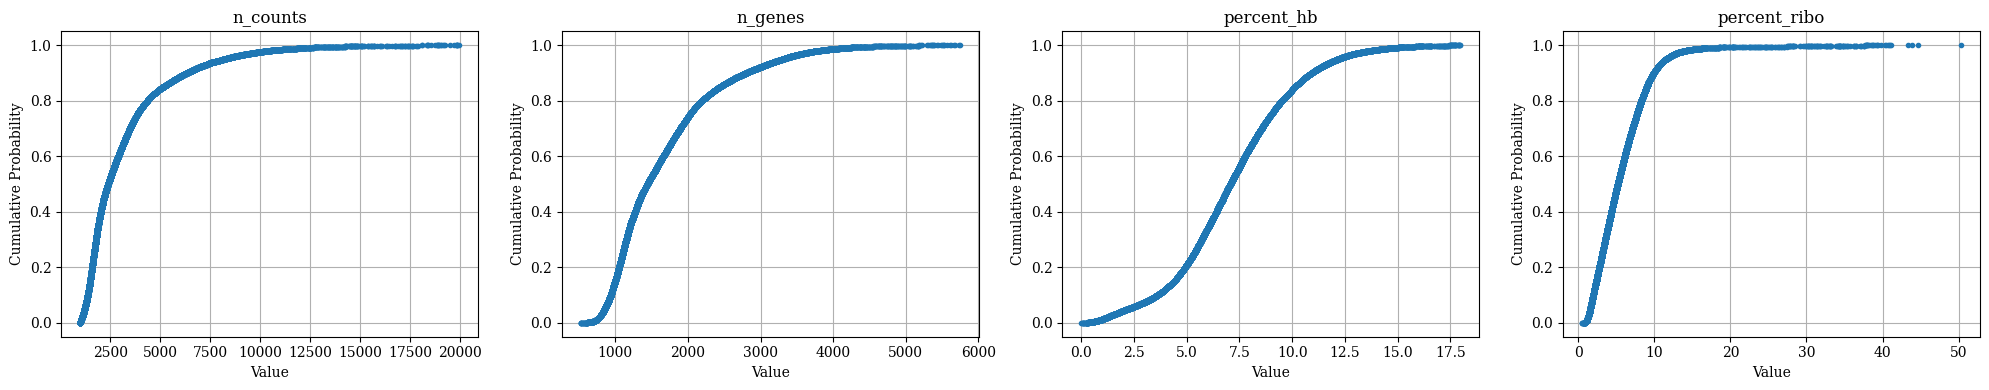

In [7]:
fig, axes = plt.subplots(1, 4, figsize=(20,4))
def plot_CDF(data, title, ax):
    x = np.sort(data)
    y = np.arange(1, len(data) + 1) / len(data)
    ax.plot(x, y, marker='.', linestyle='none')
    ax.set_xlabel('Value')
    ax.set_ylabel('Cumulative Probability')
    ax.set_title(title)
    ax.grid(True)

plot_CDF(adata_rna.obs.n_counts, 'n_counts', axes[0])
plot_CDF(adata_rna.obs.n_genes, 'n_genes', axes[1])
plot_CDF(adata_rna.obs.percent_mito, 'percent_hb', axes[2])
plot_CDF(adata_rna.obs.percent_ribo, 'percent_ribo', axes[3])
plt.tight_layout()
plt.show()

In [13]:
# apply filtering: cell weise 
adata_rna = adata_rna[adata_rna.obs.cell_passed_qc]

In [17]:
(adata_rna.X!=0).sum(axis=1).min()

692

## Save

In [25]:
adata_rna.obs = adata_rna.obs.drop(columns=['n_counts', 'log1p_n_counts', 'n_genes', 'log1p_n_genes', 'percent_mito', 'n_counts_mito', 'percent_ribo', 'n_counts_ribo', 'percent_top50', 'cell_passed_qc'])
adata_rna.var = adata_rna.var.drop(columns=['mito', 'ribo', 'n_counts', 'n_cells'])
del adata_rna.uns

map_names = {'donor_0':'Donor 1', 'donor_1': 'Donor 2', 'donor_2': 'Donor 3'} 
adata_rna.obs['Donor'] = adata_rna.obs.donor_id.map(map_names)
adata_rna.obs['Cell type'] = adata_rna.obs.cell_type

adata_rna.write(f'{work_dir}/scRNA/adata_rna.h5ad')

## UMAP

In [2]:
adata_rna = ad.read_h5ad(f'{work_dir}/scRNA/adata_rna.h5ad')

In [5]:

sc.pp.normalize_total(adata_rna)
sc.pp.log1p(adata_rna)
sc.pp.scale(adata_rna)

sc.pp.highly_variable_genes(adata_rna, n_top_genes=2000)

adata_rna_hvg = adata_rna[:, adata_rna.var.highly_variable]


sc.pp.neighbors(adata_rna_hvg)
sc.tl.umap(adata_rna_hvg)

         Falling back to preprocessing with `sc.pp.pca` and default params.


/root/.local/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)
/root/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Text(0, 0.5, '')

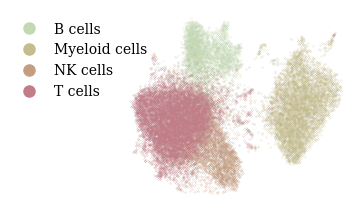

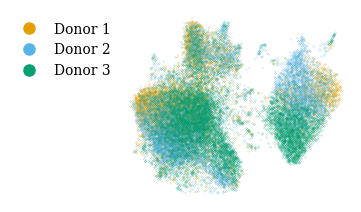

In [76]:
from local_utils import plots 
figsize = (3, 2.5)
fig, ax = plt.subplots(1, 1, figsize=figsize, sharey=False)
bbox_to_anchor = (-.5, 1)
s = .02
plots.plot_umap(adata_rna_hvg, color='cell_type', palette=plots.colors_cell_type, ax=ax, 
                bbox_to_anchor=bbox_to_anchor, s=s)
ax.spines[['left', 'bottom']].set_visible(False)
ax.set_xlabel('')
ax.set_ylabel('')
# ax.set_title('Cell type')
# ax.get_legend().get_title().set_fontweight('bold')

fig, ax = plt.subplots(1, 1, figsize=figsize, sharey=False)
plots.plot_umap(adata_rna_hvg, color='Donor', palette=plots.colors_blind, 
                ax=ax, bbox_to_anchor=bbox_to_anchor, s=s)
# ax.get_legend().get_title().set_fontweight('bold')
# ax.set_title('Donor')
ax.spines[['left', 'bottom']].set_visible(False)
ax.set_xlabel('')
ax.set_ylabel('')



# scATAC-seq

## Formatize the data

In [47]:
# extract only peaks
peaks_locations = multiome_var_meta[multiome_var_meta['feature_type']=='Peaks']['location'].values
df_peaks = multiome_train[multiome_train['location'].isin(peaks_locations)].reset_index(drop=True)
# del multiome_train

# make adata for each donor and save
def extract_count(count='count'):
    df_peaks_table = df_peaks.pivot_table(index='obs_id', columns='location', values=count)
    df_peaks_table.fillna(0, inplace=True)
    print('df_peaks table created')
    return df_peaks_table
df_peaks_table = extract_count(count='count')
# create adata
X = csr_matrix(df_peaks_table.values)
locations = df_peaks_table.columns
obs_ids = df_peaks_table.index
cell_types = []
for cell in obs_ids:
    cell_types.append(multiome_obs_meta[multiome_obs_meta['obs_id'] == cell].cell_type.values[0])




In [36]:
obs = pd.DataFrame(index=obs_ids)
obs['cell_type'] = cell_types
var = pd.DataFrame(index=locations)
adata_atac = ad.AnnData(X=X, obs=obs, var=var)
print('adata is created')

adata is created


In [37]:
split = adata_atac.var_names.str.split(r"[:-]")
adata_atac.var["chrom"] = split.map(lambda x: x[0]).astype(str)
adata_atac.var["chromStart"] = split.map(lambda x: x[1]).astype(int)
adata_atac.var["chromEnd"] = split.map(lambda x: x[2]).astype(int)
adata_atac.var.head()

,chrom,chromStart,chromEnd
location,,,
GL000194.1:100992-101876,GL000194.1,100992,101876
GL000194.1:104344-105163,GL000194.1,104344,105163
GL000194.1:110741-111545,GL000194.1,110741,111545
GL000194.1:114513-115368,GL000194.1,114513,115368
GL000194.1:27939-28826,GL000194.1,27939,28826


In [38]:
mask_standard_dna = adata_atac.var['chrom'].str.match(r'^chr(?:\d+|X|Y)$')
adata_atac = adata_atac[:,mask_standard_dna]

In [39]:
# add donor info
adata_atac.obs = pd.merge(adata_atac.obs, multiome_obs_meta[['obs_id', 'donor_id']], on='obs_id', how='left')


In [43]:
# save
adata_atac.write(f'{work_dir}/scATAC/adata_atac.h5ad')

## UMAP plot using scATAC-seq


In [66]:
adata_atac = ad.read_h5ad(f'{work_dir}/scATAC/adata_atac.h5ad')

In [51]:
adata_atac.layers['counts'] = adata_atac.X.copy()

In [67]:
# import warnings
warnings.simplefilter("ignore")
with warnings.catch_warnings():
    sc.pp.normalize_total(adata_atac)
    sc.pp.log1p(adata_atac)
    sc.pp.highly_variable_genes(adata_atac, n_top_genes=2000)
    sc.tl.pca(adata_atac, svd_solver='arpack', use_highly_variable=True)
    sc.pp.neighbors(adata_atac, n_neighbors=10, n_pcs=50)
    sc.tl.umap(adata_atac)
adata_atac

AnnData object with n_obs × n_vars = 25551 × 135358
    obs: 'obs_id', 'cell_type', 'donor_id', 'cell_type_original', 'Donor', 'Cell type'
    var: 'chrom', 'chromStart', 'chromEnd', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [1]:
from local_utils import plots 
figsize = (3, 2.5)
fig, ax = plt.subplots(1, 1, figsize=figsize, sharey=False)
bbox_to_anchor = (-.5, 1)
s = .05
plots.plot_umap(adata_atac, color='cell_type', palette=plots.colors_cell_type, ax=ax, 
                bbox_to_anchor=bbox_to_anchor, s=s, legend=False)
ax.spines[['left', 'bottom']].set_visible(False)
ax.set_xlabel('')
ax.set_ylabel('')

fig, ax = plt.subplots(1, 1, figsize=figsize, sharey=False)
plots.plot_umap(adata_atac, color='donor_id', palette=plots.colors_blind, 
                ax=ax, bbox_to_anchor=bbox_to_anchor, s=s, legend=False)
ax.spines[['left', 'bottom']].set_visible(False)
ax.set_xlabel('')
ax.set_ylabel('')

fig, ax = plt.subplots(1, 1, figsize=figsize, sharey=False)
plots.plot_umap(adata_atac, color='positive_control', palette=['blue','cyan'], 
                ax=ax, bbox_to_anchor=bbox_to_anchor, s=s, legend=False)
ax.spines[['left', 'bottom']].set_visible(False)
ax.set_xlabel('')
ax.set_ylabel('')


NameError: name 'plt' is not defined